# Imports

In [1]:
%matplotlib inline
import pandas as pd
import os
import time
import regex
import re
import string
from gensim import utils
import gensim.parsing.preprocessing as gsp
from sklearn.utils import shuffle
from datetime import datetime, timedelta
import gc
import numpy as np
from numpy import nan

In [ ]:
gc.enable()

# Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/russia-ukraine-sentiment-analysis/data"

## Read

In [ ]:
filename = 'labelled_data.csv'
data_en = pd.read_csv(os.path.join(path, filename),lineterminator='\n')

FileNotFoundError: ignored

In [ ]:
data_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380829 entries, 0 to 380828
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      380829 non-null  int64 
 1   userid          380829 non-null  int64 
 2   username        380829 non-null  object
 3   acctdesc        304559 non-null  object
 4   location        237085 non-null  object
 5   following       380829 non-null  int64 
 6   followers       380829 non-null  int64 
 7   totaltweets     380829 non-null  int64 
 8   usercreatedts   380829 non-null  object
 9   tweetid         380829 non-null  int64 
 10  tweetcreatedts  380829 non-null  object
 11  retweetcount    380829 non-null  int64 
 12  text            380829 non-null  object
 13  hashtags        380829 non-null  object
 14  language        380829 non-null  object
 15  coordinates     171 non-null     object
 16  favorite_count  380829 non-null  int64 
 17  extractedts     380829 non-nu

In [ ]:
data_en = data_en.drop(['userid', 'acctdesc', 'username', 'language', 'coordinates', 'extractedts'], axis=1)

## Process

In [ ]:
!pip install unidecode
!pip install swifter
!pip install autocorrect

In [ ]:
import swifter
import unidecode
from autocorrect import Speller

In [ ]:
data_en["tweetcreatedts"] = pd.to_datetime(data_en["tweetcreatedts"])
data_en["usercreatedts"] = pd.to_datetime(data_en["usercreatedts"])

In [ ]:
def clean_text(s):
    s = s.lower()
    s = s.replace('amp', '')
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    s = emoji_pattern.sub(r'', s) # no emoji
    s = re.sub(r"( )+$|(\n|\\n)|((https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b)|(#\S*)|(@[A-Za-z0-9_]+)", " ", s, flags=re.MULTILINE+re.DOTALL)
    return s

"""WARNING: THIS IS SLOW!!!"""
def clean_text_keep_tag(s):
    s = s.lower()
    s = s.replace('amp', '')
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    s = emoji_pattern.sub(r'', s) # no emoji
    s = re.sub(r"(@[A-Za-z0-9_]+)|((https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b)|(,|:|\.)", " ", s, flags=re.DOTALL+re.MULTILINE)
    s = re.sub(r"(( |\n|)#[^# ]+?)+(| )+$", " ", s, flags=re.DOTALL+re.MULTILINE)
    s = re.sub(r"(#)|(\\n)","",s, flags=re.DOTALL+re.MULTILINE)
    return s

In [ ]:
start_time = time.time()
data_en["cleaned_text"] = data_en.swifter.apply(lambda x: clean_text(x["text"]), axis=1)
print("Took", time.time() - start_time, "s to run.")

Pandas Apply:   0%|          | 0/380829 [00:00<?, ?it/s]

Took 20.127599239349365 s to run.


In [ ]:
to_drop = [col for col in data_en.columns if 'Unnamed:' in col]
data_en = data_en.drop(to_drop, axis=1)

In [ ]:
spell = Speller(lang = "en", fast=True)

In [ ]:
data_en["cleaned_text"] = data_en.swifter.apply(lambda x: spell(x["cleaned_text"]), axis=1)

Pandas Apply:   0%|          | 0/380829 [00:00<?, ?it/s]

In [ ]:
filters = [
           gsp.strip_tags,
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short,
          ]

def clean_text_gsp(s):
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [ ]:
start_time = time.time()
data_en["cleaned_text"] = data_en.swifter.apply(lambda x: clean_text_gsp(x["cleaned_text"]), axis=1)
print("Took", time.time() - start_time, "s to run.")

Pandas Apply:   0%|          | 0/380829 [00:00<?, ?it/s]

Took 17.57994031906128 s to run.


In [ ]:
data_nona = data_en.dropna(subset=['cleaned_text'])

In [ ]:
filename = 'gsp_lb_nona_227-311.csv.zip'
data_en.to_csv(os.path.join(path, filename), compression="zip")

## Read from...

In [4]:
filename = 'gsp_lb_nona_227-311.csv.zip'
data_nona = pd.read_csv(os.path.join(path, filename), lineterminator='\n', index_col=False)

In [5]:
data_nona.head(3)

,Unnamed: 0,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,favorite_count,tags,support,cleaned_text
0,0,PT 🇵🇹,87,64,2106,2020-06-08 15:49:09,1500984999255977986,2022-03-08 00:01:25,0,Russian embassy in lisbon right now. Colors of...,"[{'text': 'Ukraine', 'indices': [47, 55]}, {'t...",0,"['ukraine', 'standwithukraine', 'supportukrain...",ukraine,russian embassy lisbon right colors
1,1,NaN,1,2,2,2022-03-02 12:36:02,1500985027202588675,2022-03-08 00:01:32,0,#standwithukraine #Ukraine️ #NoPutin #IStandW...,"[{'text': 'standwithukraine', 'indices': [0, 1...",0,"['standwithukraine', 'ukraine️', 'noputin', 'i...",ukraine,proceeds donated ukrainian aid
2,2,worcester england,637,156,1076,2009-03-27 15:46:41,1500985058525687810,2022-03-08 00:01:39,0,Hope Putin gets a rocket up his ass ! 🚀\n#boyc...,"[{'text': 'boycottrussia', 'indices': [40, 54]...",0,"['boycottrussia', 'russiasucks', 'putinisawarc...",ukraine,hope putin gets rocket ass


# Keras
problem: training set is very unbalanced, too many pro-ukraine data, so the result is also very pro-ukraine.  
and, if the network predicts 'ukraine' for every input, the accuracy is still pretty high, right?

In [6]:
import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf

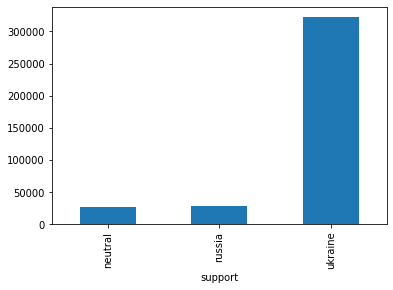

In [ ]:
data_nona.groupby(['support']).size().plot(kind='bar')

In [7]:
mask = data_nona['support'] == 'ukraine'
df_ukr = data_nona[mask].sample(n = 27000)
df_oth = data_nona[~mask]
data_sampled = shuffle(pd.concat([df_ukr, df_oth]))

In [8]:
sentences = data_sampled['cleaned_text'].values
y = data_sampled['support'].values
print(y)
y = pd.factorize(y, sort=True)[0]
# 0: neutral, 1: russia, 2: ukraine
print(y)

['ukraine' 'neutral' 'ukraine' ... 'ukraine' 'ukraine' 'ukraine']
[2 0 2 ... 2 2 2]


In [9]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Vectorize

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

CountVectorizer()

In [ ]:
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<282807x36041 sparse matrix of type '<class 'numpy.int64'>'
	with 2187497 stored elements in Compressed Sparse Row format>

In [ ]:
input_dim = X_train.shape[1]  # Number of features

## Simple keras model

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                360420    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 360,431
Trainable params: 360,431
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/20
28281/28281 [==============================] - 170s 6ms/step - loss: -90.0515 - accuracy: 0.8109 - val_loss: -125.9120 - val_accuracy: 0.8039
Epoch 2/20
28281/28281 [==============================] - 169s 6ms/step - loss: -176.6603 - accuracy: 0.8107 - val_loss: -224.5357 - val_accuracy: 0.8060
Epoch 3/20
28281/28281 [==============================] - 169s 6ms/step - loss: -292.2341 - accuracy: 0.8104 - val_loss: -351.4478 - val_accuracy: 0.7877
Epoch 4/20
28281/28281 [==============================] - 168s 6ms/step - loss: -437.1613 - accuracy: 0.8108 - val_loss: -506.3322 - val_accuracy: 0.7982
Epoch 5/20
28281/28281 [==============================] - 168s 6ms/step - loss: -610.7833 - accuracy: 0.8107 - val_loss: -688.6533 - val_accuracy: 0.8008
Epoch 6/20
28281/28281 [==============================] - 167s 6ms/step - loss: -813.4730 - accuracy: 0.8104 - val_loss: -899.9010 - val_accuracy: 0.7996
Epoch 7/20
28281/28281 [==============================] - 167s 6ms/step - los

In [ ]:
model.save(os.path.join(path, 'basic20'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/russia-ukraine-sentiment-analysis/data/basic20/assets


### Accuracy

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8181
Testing Accuracy:  0.8051


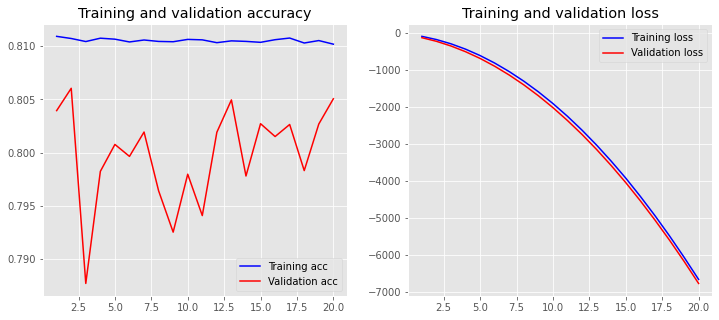

In [ ]:
plot_history(history)

### Prediction

In [ ]:
for i in range(50,60):
  Xnew = X_test[i]
  print(sentences_test[i])
  ynew = model.predict(Xnew).astype(int)[0][0]
  print(ynew)

happy women day today salute women ukraine strength determination shown putin dominate ukraine
0
graffiti prague dedicated ukrainian children
0
thank letter dated march suggested edits
0
vinnytsia source
0
know america scene triggered instabilities good countries benefits time reconsider america policy
1
church built
0
comment better reach sending prayers hope follow watch video
0
amazing news
0
russian scrap metal ukrainian farmers
0
orders stop attacking civilians bombing carnage continue
0


## Word embedding

In [11]:
tokenizer = Tokenizer(num_words=9000)
tokenizer.fit_on_texts(sentences_train)
X_train_tk = tokenizer.texts_to_sequences(sentences_train)
X_test_tk = tokenizer.texts_to_sequences(sentences_test)
vocab_size = len(tokenizer.word_index) + 1

In [12]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 200
X_train_tk = pad_sequences(X_train_tk, padding='post', maxlen=maxlen)
X_test_tk = pad_sequences(X_test_tk, padding='post', maxlen=maxlen)

In [13]:
vocab_size

22393

### Embedding layer

In [ ]:
embedding_dim = 50

model_emb = Sequential()
model_emb.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
model_emb.add(layers.Flatten())
model_emb.add(layers.Dense(10, activation='relu'))
model_emb.add(layers.Dense(1, activation='sigmoid'))
model_emb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_emb.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           2116950   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                100010    
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,216,971
Trainable params: 2,216,971
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_emb.fit(X_train_tk, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_tk, y_test),
                    batch_size=10)

In [ ]:
plot_history(history)

## CNN
CNN is not suitable I suspect

In [ ]:
embedding_dim = 100

cnn = Sequential()
cnn.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
cnn.add(layers.Conv1D(128, 5, activation='relu'))
cnn.add(layers.GlobalMaxPooling1D())
cnn.add(layers.Dense(10, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy'])
cnn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 200, 100)          2240400   
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_28 (Dense)            (None, 10)                1290      
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,305,829
Trainable params: 2,305,829
Non-trainable params: 0
___________________________________________

In [ ]:
epochs = 10
history = cnn.fit(X_train_tk, y_train,
                  epochs=epochs,
                  verbose=True,
                  validation_data=(X_test_tk, y_test),
                  batch_size=10)

Epoch 1/10
6108/6108 [==============================] - 29s 5ms/step - loss: 0.0224 - accuracy: 0.3352 - val_loss: 0.0212 - val_accuracy: 0.3408
Epoch 2/10
6108/6108 [==============================] - 28s 5ms/step - loss: -0.0088 - accuracy: 0.3353 - val_loss: 0.0264 - val_accuracy: 0.3408
Epoch 3/10
6108/6108 [==============================] - 28s 5ms/step - loss: -0.0691 - accuracy: 0.3353 - val_loss: 0.0286 - val_accuracy: 0.3408
Epoch 4/10
5343/6108 [=========================>....] - ETA: 3s - loss: -0.3456 - accuracy: 0.3350

KeyboardInterrupt: ignored

Training Accuracy: 0.7975
Testing Accuracy:  0.7925


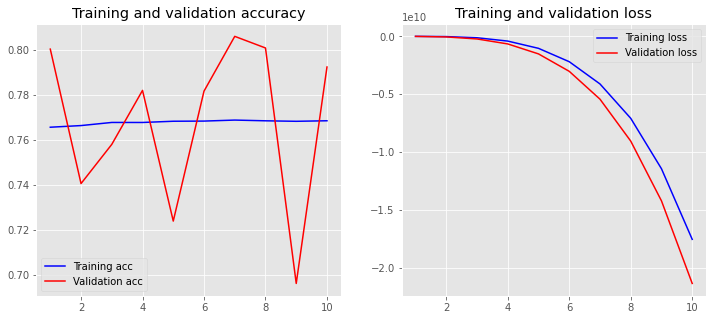

In [ ]:
loss, accuracy = cnn.evaluate(X_train_tk, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = cnn.evaluate(X_test_tk, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
cnn.save(os.path.join(path, f'cnn{epochs}'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/russia-ukraine-sentiment-analysis/data/cnn10/assets


## RNN

In [14]:
embedding_dim = 50

rnn = Sequential()
rnn.add(layers.Embedding(input_dim=vocab_size, 
                         output_dim=embedding_dim, 
                         input_length=maxlen))
rnn.add(layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
rnn.add(layers.Bidirectional(tf.keras.layers.LSTM(32)))
rnn.add(layers.Dense(64, activation='relu'))
rnn.add(layers.Dropout(0.5))
rnn.add(layers.Dense(1))
rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy'])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           1119650   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
epochs = 10
history = rnn.fit(X_train_tk, y_train,
                  epochs=epochs,
                  verbose=True,
                  validation_data=(X_test_tk, y_test),
                  batch_size=10)

Epoch 1/10
6108/6108 [==============================] - 155s 25ms/step - loss: 0.0734 - accuracy: 0.3383 - val_loss: -0.1003 - val_accuracy: 0.3315
Epoch 2/10
6108/6108 [==============================] - 147s 24ms/step - loss: 0.0520 - accuracy: 0.3383 - val_loss: -0.0996 - val_accuracy: 0.3315
Epoch 3/10
6108/6108 [==============================] - 148s 24ms/step - loss: 0.0358 - accuracy: 0.3384 - val_loss: -0.0996 - val_accuracy: 0.3315
Epoch 4/10
6108/6108 [==============================] - 150s 25ms/step - loss: 0.0362 - accuracy: 0.3384 - val_loss: -0.0996 - val_accuracy: 0.3315
Epoch 5/10
6108/6108 [==============================] - 149s 24ms/step - loss: 0.0353 - accuracy: 0.3384 - val_loss: -0.1018 - val_accuracy: 0.3316
Epoch 6/10
6108/6108 [==============================] - 147s 24ms/step - loss: 0.0330 - accuracy: 0.3385 - val_loss: -0.1027 - val_accuracy: 0.3315
Epoch 7/10
6108/6108 [==============================] - 145s 24ms/step - loss: 0.0314 - accuracy: 0.3385 - val_l

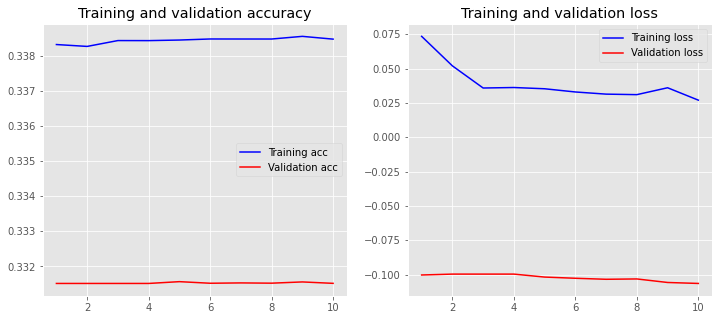

In [ ]:
plot_history(history)

In [ ]:
rnn.save(os.path.join(path, f'rnn{epochs}'))

## Hyperparameter tuning

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'

In [ ]:
model_grid = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=10,
                        verbose=True)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

# Save and evaluate results
with open(os.path.join(path, output_file), 'a') as f:
    s = ('Running {} data set\nBest Accuracy : '
         '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)

# Read model

In [ ]:
rnn_model = keras.models.load_model(os.path.join(path, 'rnn14'))

In [ ]:
loss, accuracy = rnn_model.evaluate(X_train_tk, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = rnn_model.evaluate(X_test_tk, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))